In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import pandas as pd
import time
from multiprocessing import Pool
from scipy.optimize import root_scalar
import os

#Define number of cores to be employed for the execution
num_cores = 8
tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)

num_cores = 8
tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)


#Freezing the model for reproduction
seed_value = 108

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

#Define model parameters
class PINN:
    def __init__(self, num_inputs, layers, num_outputs, E1, E2, A1, A2, Llevo, Ldesno, h, Ks):
        self.model = self.build_model(num_inputs, layers, num_outputs)
        self.E1 = E1
        self.E2 = E2
        self.A1 = A1
        self.A2 = A2
        self.Llevo = Llevo
        self.Ldesno = Ldesno
        self.h = h
        self.Ks = Ks

    def build_model(self, num_inputs, layers, num_outputs):
        activation = 'tanh'
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        x = inputs
        for layer in layers:
            x = tf.keras.layers.Dense(layer, activation=activation, kernel_initializer='he_normal')(x)
        outputs = tf.keras.layers.Dense(num_outputs, kernel_initializer='he_normal')(x)
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

    def exact_solution(self, alphai, betai):
        return 2*self.E2*self.A2*(np.tan(alphai)/(np.tan(betai)+np.tan(alphai))*np.cos(beta0)/np.cos(betai)-(self.Ldesno/(L)))*(np.cos(betai)*np.tan(alphai) + np.sin(betai)) - self.Ks*(self.h - ((L)*np.tan(betai)*np.tan(alphai))/(np.tan(betai) + np.tan(alphai)))

    def loss(self, x, y_true):
        y_pred = self.model(x)
        return tf.reduce_mean(tf.square((y_true - y_pred)/total_samples))

    def train(self, x_train, y_train, epochs, optimizer):
        best_loss = np.inf
        patience = 30  
        patience_counter = 0 

        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                loss_value = self.loss(x_train, y_train)
            grads = tape.gradient(loss_value, self.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

            if loss_value < best_loss:
                best_loss = loss_value
                patience_counter = 0
                if epoch % 500 == 0:
                    print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, Improvement!")
            else:
                patience_counter += 1
                if epoch % 500 == 0:
                    print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, No improvement for {patience_counter} epochs.")
    
    #Updating parameters for new data
    def update_parameters(self, E1, E2, A1, A2, Llevo, Ldesno, h, Ks):
        #Physical parameters
        self.E1 = E1
        self.E2 = E2
        self.A1 = A1
        self.A2 = A2
        self.Llevo = Llevo
        self.Ldesno = Ldesno
        self.h = h
        self.Ks = Ks

    def predict(self, x_new1, x_new2):
        return self.loss(x_test, self.model.predict(x_new1, x_new2))

    def train_loss(self, x_train, y_train):
        train_loss_value = self.loss(x_train, y_train)
        return train_loss_value

    def test_loss(self, x_test, y_test):
        test_loss_value = self.loss(x_test, y_test)
        return test_loss_value

    def all_loss(self, x_all, y_all):
        all_loss_value = self.loss(x_all, y_all)
        return all_loss_value

#Network parameters
num_inputs = 2  
layers = [60, 60, 60] 
num_outputs = 1

#Number of samples
num_train_samples = 8000
num_test_samples = 2000
total_samples = num_train_samples + num_test_samples

#Input values
E1, E2, A1, A2, Llevo, Ldesno, h, Ks = 800000, 800000, 0.01, 0.01, 3.7, 3.7, 1, 213.131
L=Llevo + Ldesno
dlevo = math.sqrt(Llevo**2+h**2)
ddesno = math.sqrt(Ldesno**2+h**2)
alpha0 = math.asin(h/dlevo)
beta0 = math.asin(h/ddesno)

#Spring stiffness
Ku = 0 #Nondimensional stiffness
ks = Ku*((E1*A1+E2*A2)/2)*(math.sin(alpha0)**3)/h
print("Ku =", Ku)
print("ks =", ks)

#Alpha and beta angles
tg = h / Llevo
atg = math.atan(tg)
print("tg =", tg)
print("angle =", np.rad2deg(atg))
#Case E1!=E2
if E1!=E2:
    if tg <= 0.100:   #0-5 degree
        alphai = 0.3 * np.random.uniform(-1, 1, total_samples)
    elif tg <= 0.200: #5-10 degree
        alphai = 0.5 * np.random.uniform(-1, 1, total_samples)
    elif tg <= 0.300: #10-15 degree
        alphai = 0.6 * np.random.uniform(-1, 1, total_samples)
    elif tg <= 0.400: #15-20 degree
        alphai = 0.7 * np.random.uniform(-1, 1, total_samples)
    elif tg <= 0.465: #20-25 degree
        alphai = 0.9 * np.random.uniform(-1, 1, total_samples)
    else:             #25-30 degree
        alphai = 1.0 * np.random.uniform(-1, 1, total_samples)

#Case E1==E2
else:
    if tg <= 0.100:   #0-5 degree
        alphai = 0.3 * np.random.uniform(-1, 1, total_samples)
    elif tg <= 0.200: #5-10 degree
        alphai = 0.5 * np.random.uniform(-1, 1, total_samples)
    elif tg <= 0.300: #10-15 degree
        alphai = 0.6 * np.random.uniform(-1, 1, total_samples)
    elif tg <= 0.400: #15-20 degree
        alphai = 0.7 * np.random.uniform(-1, 1, total_samples)
    elif tg <= 0.465: #20-25 degree
        alphai = 0.9 * np.random.uniform(-1, 1, total_samples)
    else:             #25-30 degree
        alphai = 1.0 * np.random.uniform(-1, 1, total_samples)

#Betai angles calculation
def func(x, alphai):
    return (np.cos(x)/np.cos(alphai)) * (2*L*math.tan(alphai)/(math.tan(x)+math.tan(alphai))*math.cos(alpha0)/(L*math.cos(x))-1) - (E1*A1/(E2*A2)) * (2*(L-L*math.tan(alphai)/(math.tan(x)+math.tan(alphai)))*math.cos(alpha0)/(L*math.cos(alphai))-1)

results = []
for alphai in alphai:

    current_func = lambda x: func(x, alphai)

    bracket = [0, 1] if alphai >= 0 else [-1, 0]

    try:
        sol = root_scalar(current_func, bracket=bracket, method='brentq')
        results.append((alphai, sol.root))
    except ValueError:
        results.append((alphai, 'No root found', None, False))

df_results = pd.DataFrame(results, columns=['Alphai', 'Root'])


df_results.to_excel("Root_Values.xlsx", index=False)

alphai = df_results['Alphai'].values
betai = df_results['Root'].values

#PINN model
pinn = PINN(num_inputs, layers, num_outputs, E1, E2, A1, A2, Llevo, Ldesno, h, Ks)

#Data split
x_train_1 = alphai[:num_train_samples].reshape(-1, 1)
x_train_2 = betai[:num_train_samples].reshape(-1, 1)
x_test_1 = alphai[num_train_samples:].reshape(-1, 1)
x_test_2 = betai[num_train_samples:].reshape(-1, 1)
x_all_1 = alphai.reshape(-1, 1)
x_all_2 = betai.reshape(-1, 1)

#Train/Test set input
x_train = np.column_stack((x_train_1, x_train_2))
x_test = np.column_stack((x_test_1, x_test_2))
x_all = np.column_stack((x_all_1, x_all_2))

#Train/Test set output
y_train = np.array([pinn.exact_solution(v1, v2) for v1, v2 in zip(x_train_1, x_train_2)])
y_test = np.array([pinn.exact_solution(v3, v4) for v3, v4 in zip(x_test_1, x_test_2)])

#Training time
start = time.time()

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01) 
pinn.train(x_train, y_train, epochs=6000, optimizer=optimizer) 

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')


Ku = 0
ks = 0.0
tg = 0.27027027027027023
angle = 15.124007308310565
Epoch 0, Loss: 0.006627783644944429, Improvement!
Epoch 500, Loss: 0.003989973105490208, Improvement!
Epoch 1000, Loss: 0.0025783570017665625, Improvement!
Epoch 1500, Loss: 0.001688300515525043, Improvement!
Epoch 2000, Loss: 0.0011085461592301726, Improvement!
Epoch 2500, Loss: 0.0007260101847350597, Improvement!
Epoch 3000, Loss: 0.0004738451971206814, Improvement!
Epoch 3500, Loss: 0.00030810452881269157, Improvement!
Epoch 4000, Loss: 0.0001995289057958871, Improvement!
Epoch 4500, Loss: 0.0001280734286410734, Improvement!
Epoch 5000, Loss: 9.144646173808724e-05, No improvement for 14 epochs.
Epoch 5500, Loss: 5.233956835581921e-05, Improvement!
Running Time:  517.0860850811005  seconds


In [2]:
#Train output
y_train = pinn.exact_solution(x_train[:, 0], x_train[:, 1])

#Train loss
train_loss = pinn.train_loss(x_train, y_train)

#Print train loss
print(f"Train Loss: {train_loss.numpy()}")

#Test output
y_test = pinn.exact_solution(x_test[:, 0], x_test[:, 1])

#Test loss
test_loss = pinn.test_loss(x_test, y_test)

#Print test loss
print(f"Test Loss: {test_loss.numpy()}")

#All output
y_all = pinn.exact_solution(x_all[:, 0], x_all[:, 1])

#All loss
all_loss = pinn.all_loss(x_all, y_all)

#Print all loss
print(f"All Loss: {all_loss.numpy()}")

Train Loss: 0.012077335268259048
Test Loss: 0.012483576312661171
All Loss: 0.012159870937466621


313/313 [==============================] - 1s 2ms/step


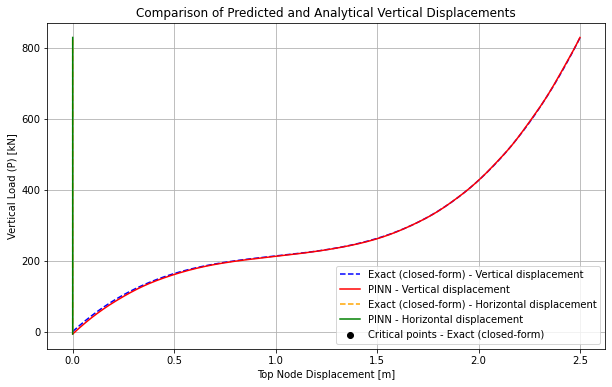

In [3]:
#VERTICAL/HORIZONTAL DISPLACEMENT VS FORCE + CRITICAL POINTS
x_plot = np.linspace(0, -2.5, total_samples).reshape(-1, 1)
alphai = np.linspace(alpha0, -1.5*alpha0, total_samples)

#Betai angles
def func(x, alphai):
    return (np.cos(x)/np.cos(alphai)) * (2*L*math.tan(alphai)/(math.tan(x)+math.tan(alphai))*math.cos(alpha0)/(L*math.cos(x))-1) - (E1*A1/(E2*A2)) * (2*(L-L*math.tan(alphai)/(math.tan(x)+math.tan(alphai)))*math.cos(alpha0)/(L*math.cos(alphai))-1)

results = []
for alphai in alphai:
    
    current_func = lambda x: func(x, alphai)
    
    bracket = [0, 1] if alphai >= 0 else [-1, 0]
    
    try:
        sol = root_scalar(current_func, bracket=bracket, method='brentq')
        results.append((alphai, sol.root)) #,sol.iterations, sol.converged))
    except ValueError:
        results.append((alphai, 'No root found', None, False))
        
df_results = pd.DataFrame(results, columns=['Alphai', 'Betai'])


df_results.to_excel("Root_Values.xlsx", index=False)

angle_za_exact_alpha = df_results['Alphai'].values
angle_za_exact_beta = df_results['Betai'].values

def find_critical_points_exact(y):
    dy = np.diff(y)
    critical_points_exact = np.where(np.diff(np.sign(dy)))[0]
    return critical_points_exact + 1

#EXACT SOLUTION
y_exact = pinn.exact_solution(angle_za_exact_alpha, angle_za_exact_beta)

critical_points_indices_exact = find_critical_points_exact(y_exact)
x_coord_exact = x_plot[critical_points_indices_exact]
y_coord_exact = y_exact[critical_points_indices_exact]

#PINN SOLUTION
predictive_set = np.column_stack((angle_za_exact_alpha, angle_za_exact_beta))
y_pred = pinn.model.predict(predictive_set)
y_pred = y_pred.flatten()

#CRITICAL POINTS
def find_growing_dropping_points(y):
    dy = np.diff(y)
    critical_indices = np.where(np.diff(np.sign(dy)))[0]  
    adjusted_indices = critical_indices + 1  

    growing_points = []
    dropping_points = []

    for i in adjusted_indices:
        if i == 0 or i == len(y) - 1:
            continue 
        if dy[i - 1] > 0 and dy[i] < 0:
            dropping_points.append(i)
        elif dy[i - 1] < 0 and dy[i] > 0:
            growing_points.append(i)
    
    return growing_points, dropping_points

growing_points_indices, dropping_points_indices = find_growing_dropping_points(y_pred)
x_growing_coord_pinn = x_plot[growing_points_indices]
y_growing_coord_pinn = y_pred[growing_points_indices]
x_dropping_coord_pinn = x_plot[dropping_points_indices]
y_dropping_coord_pinn = y_pred[dropping_points_indices]

plt.figure(figsize=(10, 6))
plt.plot(abs(x_plot), -y_exact, label='Exact (closed-form) - Vertical displacement', color='blue', linestyle='--')
plt.plot(abs(x_plot), -y_pred, label='PINN - Vertical displacement', color='red', linestyle='-')

#HORIZONTAL DISPLACEMENTS
tan_alpha = np.tan(angle_za_exact_alpha)
tan_beta = np.tan(angle_za_exact_beta)
x = L * tan_alpha / (tan_beta + tan_alpha)
x_pom = L/2-x

x_pom_np = x_pom.to_numpy() if hasattr(x_pom, 'to_numpy') else x_pom
y_exact_np = y_exact.to_numpy() if hasattr(y_exact, 'to_numpy') else y_exact
y_pred_np = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else y_pred

#PLOT HORIZONTAL DISPLACEMENTS
plt.plot(x_pom_np, -y_exact_np, label='Exact (closed-form) - Horizontal displacement', color='orange', linestyle='--')
plt.plot(x_pom_np, -y_pred_np, label='PINN - Horizontal displacement', color='green', linestyle='-')

#Plot critical points - EXACT
plt.scatter(abs(x_coord_exact), -y_coord_exact, color='black', zorder=5, label='Critical points - Exact (closed-form)')

#Plot second critical point - PINN
if len(x_growing_coord_pinn) > 0 and len(y_growing_coord_pinn) > 0: 
    plt.scatter(abs(x_growing_coord_pinn[-1]), -y_growing_coord_pinn[-1], color='green', zorder=5, label='Critical points - PINN')

#Plot first critical point - PINN
if len(x_dropping_coord_pinn) > 0 and len(y_dropping_coord_pinn) > 0:  
    plt.scatter(abs(x_dropping_coord_pinn[0]), -y_dropping_coord_pinn[0], color='green', zorder=5)
    
plt.xlabel('Top Node Displacement [m]')
plt.ylabel('Vertical Load (P) [kN]')
plt.title('Comparison of Predicted and Analytical Vertical Displacements')
plt.legend()
#plt.ylim(0, 25)
plt.grid(True)
plt.show()

In [4]:
#Print critical points
print("First critical point - Exact solution - Displacement", abs(x_coord_exact[0]))
print("First critical point - Exact solution - Force", -y_coord_exact[0])
print("Second critical point - Exact solution - Displacement", abs(x_coord_exact[-1]))
print("Second critical point - Exact solution - Force", -y_coord_exact[-1])
print("First critical point - PINN - Displacement", abs(x_dropping_coord_pinn[0]))
print("First critical point - PINN - Force", -y_dropping_coord_pinn[0])
print("Second critical point - PINN - Displacement", abs(x_growing_coord_pinn[-1]))
print("Second critical point - PINN - Force", -y_growing_coord_pinn[-1])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
#Convert the results to Excel file
x_plot = pd.DataFrame(abs(x_plot))
x_plot.to_excel("Shallow Truss VERTICAL DISPLACEMENT Ku=0.xlsx")
x_pom_np = pd.DataFrame(x_pom_np)
x_pom_np.to_excel("Shallow Truss HORIZONTAL DISPLACEMENT Ku=0.xlsx")

y_exact = pd.DataFrame(-y_exact)
y_exact.to_excel("Shallow Truss FORCE VERTICAL EXACT Ku=0.xlsx")
y_exact_np = pd.DataFrame(-y_exact_np)
y_exact_np.to_excel("Shallow Truss FORCE HORIZONTAL EXACT Ku=0.xlsx")

y_pred = pd.DataFrame(-y_pred)
y_pred.to_excel("Shallow Truss FORCE VERTICAL PINN Ku=0.xlsx")
y_pred_np = pd.DataFrame(-y_pred_np)
y_pred_np.to_excel("Shallow Truss FORCE HORIZONTAL PINN Ku=0.xlsx")

In [6]:
# Calculate spring stiffness
Ku_02 = 0.2 #Nondimensional stiffness
ks = Ku_02*((E1*A1+E2*A2)/2)*(math.sin(alpha0)**3)/h #Stiffness
print("Ku_0.2 =", Ku_02)
print("ks_0.2 =", ks)

Ku_04 = 0.4 
ks = Ku_04*((E1*A1+E2*A2)/2)*(math.sin(alpha0)**3)/h 
print("Ku_0.4 =", Ku_04)
print("ks_0.4 =", ks)

Ku_06 = 0.6 
ks = Ku_06*((E1*A1+E2*A2)/2)*(math.sin(alpha0)**3)/h 
print("Ku_0.6 =", Ku_06)
print("ks_0.6 =", ks)

Ku_08 = 0.8 
ks = Ku_08*((E1*A1+E2*A2)/2)*(math.sin(alpha0)**3)/h 
print("Ku_0.8 =", Ku_08)
print("ks_0.8 =", ks)

Ku_10 = 1.0 
ks = Ku_10*((E1*A1+E2*A2)/2)*(math.sin(alpha0)**3)/h 
print("Ku_1.0 =", Ku_10)
print("ks_1.0 =", ks)

Ku_15 = 1.5 
ks = Ku_15*((E1*A1+E2*A2)/2)*(math.sin(alpha0)**3)/h 
print("Ku_1.5 =", Ku_15)
print("ks_1.5 =", ks)

Ku_0.2 = 0.2
ks_0.2 = 28.41759293590465
Ku_0.4 = 0.4
ks_0.4 = 56.8351858718093
Ku_0.6 = 0.6
ks_0.6 = 85.25277880771395
Ku_0.8 = 0.8
ks_0.8 = 113.6703717436186
Ku_1.0 = 1.0
ks_1.0 = 142.08796467952325
Ku_1.5 = 1.5
ks_1.5 = 213.1319470192849
